In [1]:
!pip install opencv-python
!pip install opencv-python-headless



In [2]:
!pip install numpy

In [3]:
!sudo apt-get install python3-pip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-pip is already the newest version (22.0.2+dfsg-1ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


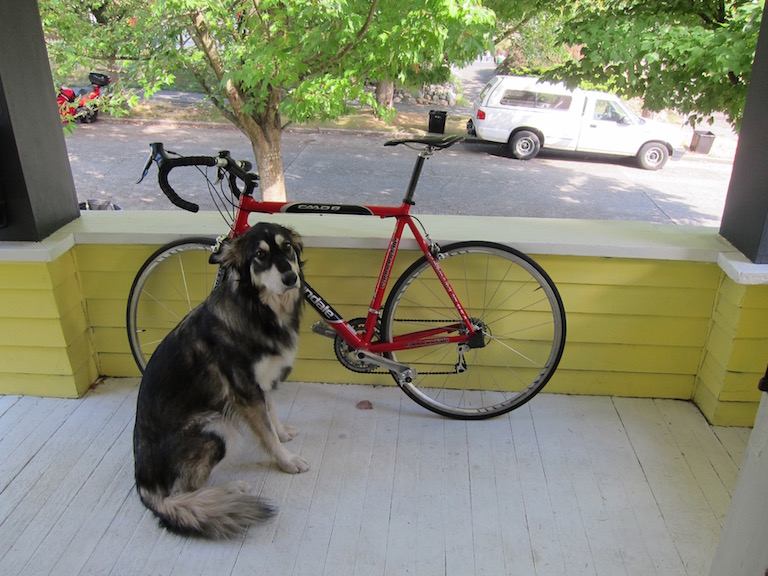

In [5]:
from google.colab.patches import cv2_imshow
import cv2

# Read the input image
image = cv2.imread('/content/drive/MyDrive/dog.jpg')

# Check if the image was read successfully
if image is None:
    print("Error: Could not read the image.")
else:
    # Display the image using cv2_imshow
    cv2_imshow(image)


In [6]:
# Define the path to the text file containing class names
classes_file_path = '/content/drive/MyDrive/yolov3.txt'

# Read class names from the text file
classes = None
with open(classes_file_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Check if class names were read successfully
if classes is None:
    print("Error: Could not read class names from the file.")
else:
    # Print the class names
    print("Class Names:")
    for class_name in classes:
        print(class_name)


Class Names:
person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush


In [7]:
import os
yolo_cfg_path = '/content/drive/MyDrive/yolov3.cfg'
yolo_weights_path = '/content/drive/MyDrive/yolov3.weights'

# Check if the YOLO configuration file exists
if os.path.isfile(yolo_cfg_path):
    print(f"YOLO configuration file '{yolo_cfg_path}' exists.")
else:
    print(f"YOLO configuration file '{yolo_cfg_path}' does not exist.")


YOLO configuration file '/content/drive/MyDrive/yolov3.cfg' exists.


In [10]:
import numpy as np
# generate different colors for different classes
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet(yolo_cfg_path, yolo_weights_path)

scale = 0.00392

# create input blob
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)

In [12]:
# function to get the output layer names
# in the architecture
def get_output_layers(net):

    layer_names = net.getLayerNames()

    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


In [15]:
def get_output_layers(net):
    layer_names = net.getLayerNames()
    unconnected_layers = net.getUnconnectedOutLayers()

    # Check if unconnected_layers is a flat array
    if unconnected_layers.ndim == 1:
        output_layers = [layer_names[i - 1] for i in unconnected_layers]
    else:
        # Assuming unconnected_layers is a 2D array
        output_layers = [layer_names[i[0] - 1] for i in unconnected_layers]

    return output_layers

# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

# Assuming 'image' is the variable holding your input image
Height, Width = image.shape[:2]

# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

# for each detection from each output layer
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


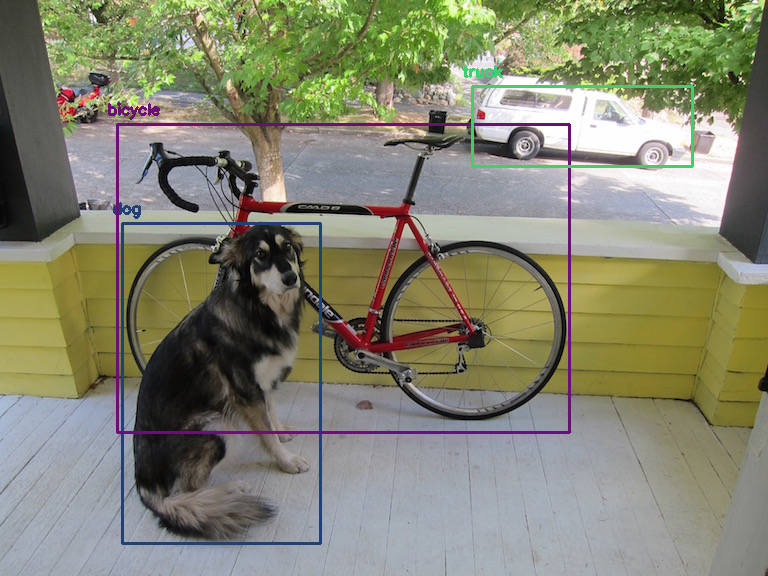

In [18]:
# apply non-max suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

# go through the detections remaining after nms and draw bounding box
for i in indices:
    # Check if indices is a flat array
    if indices.ndim == 1:
        box_index = i
    else:
        # Assuming indices is a 2D array
        box_index = i[0]

    box = boxes[box_index]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]

    draw_bounding_box(image, class_ids[box_index], confidences[box_index], round(x), round(y), round(x+w), round(y+h))

# display output image
from google.colab.patches import cv2_imshow

# display output image
cv2_imshow(image)

# wait until any key is pressed
cv2.waitKey()

# save output image to disk
cv2.imwrite("object-detection.jpg", image)

# release resources
cv2.destroyAllWindows()
